<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Logo.png" alt="Instill Logo" width="300"/>

# Generating Structured Output from LLMs

In this notebook, we will explore the performance of OpenAI's new [Structured Outputs in the
API](https://openai.com/index/introducing-structured-outputs-in-the-api/) feature, alongside multiple existing tools for generating structured outputs from LLMs. As well as providing a concise demonstration of how to use all of these tools, we will also evaluate them with respect to a task that involves both **reasoning** and **structuring outputs**, inspired by the recent publication titled [Let Me Speak Freely? A Study on the Impact of Format Restrictions on Performance of Large Language Models](https://arxiv.org/abs/2408.02442v1).

This illuminates an important problem raised in the paper: **LLMs struggle with reasoning tasks when they're placed under format restrictions**.

Besides OpenAI's new structured outputs in the API, the existing tools and libraries that we will demonstrate and test are:

1. [**Instructor**](https://python.useinstructor.com) - a Python library, built on top of Pydantic, that lets you generate structured output from LLMs
2. [**Marvin**](https://www.askmarvin.ai) - a Python library for building reliable natural language interfaces
3. [**BAML**](https://www.boundaryml.com) - a domain specific language to write and test LLM functions
4. [**TypeChat**](https://microsoft.github.io/TypeChat/) - a tool from Microsoft for getting well-typed responses from language models
5. [**LangChain**](https://www.langchain.com) - a Python library that simplifies building apps with language models by integrating them with data and APIs

[Outlines](https://outlines-dev.github.io/outlines/), [JSONformer](https://github.com/1rgs/jsonformer) and [Guidance](https://github.com/guidance-ai/guidance/tree/main) were also considered, however they were left out of this experiment as they had limited support for remote API calls and failed when integrating with the OpenAI API.

Finally, we will demonstrate a multi-step approach using Instill VDP, where we separate reasoning from output structuring in a two-step process that allows us to achieve strong reasoning performance from LLMs whilst also producing robust structured outputs.

### Setup

To execute all of the code in this notebook, you’ll need to create a free Instill Cloud account and setup an API Token. To create your account, please refer to our [quickstart guide](https://www.instill.tech/docs/quickstart). For generating your API Token, consult the [API Token Management](https://www.instill.tech/docs/core/token) page.

**This will give you access to 10,000 free credits per month that you can use to make API calls with third-party AI vendors. Please see our [documentation](https://www.instill.tech/docs/cloud/credit) for further details.**

Whilst you can run all Instill VDP pipelines using your 10,000 free monthly credits, please note that you will need a valid OpenAI API key to run the structured LLM output evaluations (e.g. for Instructor, Marvin, BAML, TypeChat). Once you have created one via the OpenAI website, please set it as an environment variable by running the following line, but replacing `*********` for your OpenAI API key.

In [ ]:
!export OPENAI_API_KEY='**********'

We will now install the latest Instill Python SDK, import the required libraries, and configure the SDK with a valid API token.

In [1]:
!pip install instill-sdk --quiet

In [2]:
from instill.clients import InstillClient
from instill.configuration import global_config
from google.protobuf.json_format import MessageToDict
from IPython.display import IFrame
import os
import seaborn as sns
import matplotlib.pyplot as plt

global_config.set_default(
    url="api.instill.tech",
    token="YOUR_INSTILL_API_TOKEN", # <-- Insert your Instill API token here
    secure=True,
)

client = InstillClient(async_enabled=False)

### Benchmark Task

The task we will use to test, compare and evaluate the performance of these tools is directly inspired from Figure 1 of the aforementioned [paper](https://arxiv.org/abs/2408.02442v1), which poses the question:

> Eliza's rate per hour for the first 40 hours she works each week is $10. She also receives an overtime pay of 1.2 times her regular hourly rate. If Eliza worked for 45 hours this week, how much are her earnings for this week?

In our task, we increase the complexity by combining an analogous reasoning problem with an additional text summarization task. More precisely, we ask the LLM/output structuring tool to summarize the contents of a resume into the following data model:
```Python
name: str
email: str
cost: float
reasoning: str
experience: list[str]
skills: list[str]
```
where `cost` represents the answer to the question:
> John Doe is a freelance software engineer. He charges a 
        base rate of $50 per hour for the first 29 hours of work 
        each week. For any additional hours, he charges 1.7 
        times his base hourly rate. This week, John worked on a 
        project for 38 hours. How much will John Doe charge his 
        client for the project this week?

and `reasoning` contains the rationale and steps behind the calculated cost. See below for the example resume we will use, as well as the correct `cost` response.

In [3]:
resume = """
    John Doe
    1234 Elm Street 
    Springfield, IL 62701
    (123) 456-7890
    Email: john.doe@gmail.com

    Objective: To obtain a position as a software engineer.

    Education:
    Bachelor of Science in Computer Science
    University of Illinois at Urbana-Champaign
    May 2020 - May 2024

    Experience:
    Software Engineer Intern
    Google
    May 2022 - August 2022
    - Worked on the Google Search team
    - Developed new features for the search engine
    - Wrote code in Python and C++

    Software Engineer Intern
    Facebook
    May 2021 - August 2021
    - Worked on the Facebook Messenger team
    - Developed new features for the messenger app
    - Wrote code in Python and Java
    """

question = """
    Question:
    John Doe is a freelance software engineer. He charges a 
    base rate of $50 per hour for the first 29 hours of work 
    each week. For any additional hours, he charges 1.7 
    times his base hourly rate. This week, John worked on a 
    project for 38 hours. How much will John Doe charge his 
    client for the project this week?
    """

context = resume + question

In [4]:
true_answer = (50*29) + (1.7*50*9)
print(f'Correct Answer: ${true_answer}')

Correct Answer: $2215.0


### OpenAI GPT-4o Performance Baseline

Before we take a look at various libraries and frameworks that aim to produce structured outputs from LLMs, we will first test and evaluate the performance of GPT-4o on this task, with and without enforcing structured output, by making use of the new OpenAI structured output API that is now supported in Instill VDP.

#### Unstructured Output

Here we call the [`unstructured-output`](https://instill.tech/george_strong/pipelines/unstructured-output/playground) Instill VDP pipeline to test the performance of OpenAI's GPT4o model on this task without any restriction on the output structure. It achieves the correct result.

In [5]:
openai_unstructured = client.pipeline_service.trigger_pipeline(
    'unstructured-output', [],
    [{"context": context,
      "question": question}])

openai_unstructured_dict = MessageToDict(openai_unstructured)['outputs'][0]['answer']
print(openai_unstructured_dict)

To calculate how much John Doe will charge his client for the project this week:

1. **Base Rate Calculation:**
   - John charges $50 per hour for the first 29 hours.
   - Total for 29 hours = 29 hours * $50/hour = $1,450.

2. **Overtime Rate Calculation:**
   - John worked a total of 38 hours, which means he worked 38 - 29 = 9 additional hours.
   - His overtime rate is 1.7 times his base rate: 1.7 * $50 = $85 per hour.
   - Total for 9 additional hours = 9 hours * $85/hour = $765.

3. **Total Charge:**
   - Total charge = $1,450 (base) + $765 (overtime) = $2,215.

John Doe will charge his client $2,215 for the project this week.

Additional details regarding the candidate:

1. **Name:** John Doe
2. **Email:** john.doe@gmail.com
3. **Experience:**
   - Software Engineer Intern at Google (May 2022 - August 2022)
     - Worked on the Google Search team
     - Developed new features for the search engine
     - Wrote code in Python and C++
   - Software Engineer Intern at Facebook (May 2

#### Structured Output

Here we call the [`structured-output`](https://instill.tech/george_strong/pipelines/structured-output/playground) Instill VDP pipeline, which makes use of the new Structured Outputs in the API feature. Although the same model was able to calculate the correct result when generating unstructured text output, by restricting the output format to our structured data model, we can observe that the `cost` result is incorrect.

In [6]:
openai_structured = client.pipeline_service.trigger_pipeline(
    'structured-output', [],
    [{"context": context,
      "question": question}])

openai_structured_dict = MessageToDict(openai_structured)['outputs'][0]['answer']
openai_structured_dict

{'cost': 2225.0,
 'email': 'john.doe@gmail.com',
 'skills': ['Python', 'C++', 'Java'],
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'name': 'John Doe'}

In [7]:
structured_output_error = abs(openai_structured_dict["cost"]-true_answer)
print(f'Cost calculation error: ${structured_output_error}')

Cost calculation error: $10.0


### 1. Instructor

[Instructor](https://python.useinstructor.com) is a Python library, built on top of Pydantic, that lets you generate structured output from LLMs. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [8]:
!pip install -U instructor --quiet
import instructor
from pydantic import BaseModel
from openai import OpenAI

In [9]:
class DataModel(BaseModel):
    name: str
    email: str
    cost: float
    experience: list[str]
    skills: list[str]


instructor_client = instructor.from_openai(OpenAI())

template = """
    Extract from this content:
    {resume}
    Answer the question, storing the result in cost.
    """

prompt = template.format(resume=context)

instructor_response = instructor_client.chat.completions.create(
    model="gpt-4o",
    response_model=DataModel,
    messages=[{"role": "user", "content": prompt}],
)

instructor_dict = instructor_response.model_dump()
instructor_dict

2024-08-26 16:20:50,714.714 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2139.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [10]:
instructor_error = abs(instructor_dict["cost"]-true_answer)
print(f'Cost calculation error: ${instructor_error}')

Cost calculation error: $76.0


### 2. Marvin

[Marvin](https://www.askmarvin.ai) is a Python library for building reliable natural language interfaces. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [11]:
!pip install marvin --quiet
import marvin

In [12]:
@marvin.fn
def process(
    resume:str = resume,
    question: str = question,
) -> DataModel:
    """
    Extract content from `resume`.
    Answer the `question`, storing the result in cost.
    """


marvin_response = process(resume, question)

marvin_dict = marvin_response.model_dump()
marvin_dict

2024-08-26 16:20:54,872.872 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2183.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [13]:
marvin_error = abs(marvin_dict["cost"]-true_answer)
print(f'Cost calculation error: ${marvin_error}')

Cost calculation error: $32.0


### 3. BAML

[BAML](https://www.boundaryml.com) is a domain specific language to write and test LLM functions developed by Boundary. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [14]:
!pip install baml-py
!baml-cli init

In [15]:
file_path = 'baml_src/resume.baml'

with open(file_path, 'r') as file:
    file_data = file.read()

updated_file_data = file_data.replace(
    '// Defining a data model.\nclass Resume {\n  name string\n  email string\n  experience string[]\n  skills string[]\n}',
    '// Defining a data model.\nclass Resume {\n  name string\n  email string\n  cost float\n  experience string[]\n  skills string[]\n}'
    ).replace(
    'Extract from this content:\n    {{ resume }}\n\n',
    'Extract from this content:\n    {{ resume }}\n    Answer the question, storing the result in cost.\n\n'
    )

with open(file_path, 'w') as file:
    file.write(updated_file_data)

In [16]:
!baml-cli generate
from baml_client.sync_client import b

Generated 1 baml_client


In [17]:
baml_response = b.ExtractResume(context)

baml_dict = baml_response.model_dump()
baml_dict

{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 680.0,
 'experience': ['Software Engineer Intern at Google',
  'Software Engineer Intern at Facebook'],
 'skills': ['Python', 'C++', 'Java']}

In [18]:
baml_error = abs(baml_dict["cost"]-true_answer)
print(f'Cost calculation error: ${baml_error}')

Cost calculation error: $1535.0


### 4. TypeChat

[TypeChat](https://microsoft.github.io/TypeChat/) is a tool from Microsoft for getting well-typed responses from language models. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [19]:
!pip install "typechat @ git+https://github.com/microsoft/TypeChat#subdirectory=python" --quiet
from dataclasses import dataclass
from typing_extensions import Annotated, Doc
from typing import Dict, Any
from typechat import TypeChatJsonTranslator, TypeChatValidator, create_language_model

In [20]:
@dataclass
class TypeChatDataModel:
    name: Annotated[str, Doc("The name of the candidate")]
    email: Annotated[str, Doc("The email address of the candidate")]
    cost: Annotated[float, Doc("The cost of hiring the candidate for the project")]
    experience: Annotated[list[str], Doc("A list of experiences the candidate has")]
    skills: Annotated[list[str], Doc("A list of skills the candidate possesses")]

    def to_dict(self) -> Dict[str, Any]:
        return {
            "name": self.name,
            "email": self.email,
            "cost": self.cost,
            "experience": self.experience,
            "skills": self.skills,
        }


env_vars = {'OPENAI_API_KEY': os.getenv('OPENAI_API_KEY'), 'OPENAI_MODEL': 'gpt-4o'}

model = create_language_model(env_vars)
validator = TypeChatValidator(TypeChatDataModel)
translator = TypeChatJsonTranslator(model, validator, TypeChatDataModel)

# TypeChat needed a little more help in the prompt to generate the output as numeric value!
typechat_response = await translator.translate(prompt + "The value stored in cost must be a single number of type float.")

typechat_dict = typechat_response.value.to_dict()
typechat_dict

2024-08-26 16:21:06,968.968 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 1915.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [21]:
typechat_error = abs(typechat_dict["cost"]-true_answer)
print(f'TypeChat error: ${typechat_error}')

TypeChat error: $300.0


### 5. LangChain

LangChain simplifies building apps with language models by integrating them with data and APIs. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [22]:
!pip install langchain --quiet
!pip install langchain-openai --quiet
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

In [23]:
class DataModel(BaseModel):
    name: str = Field(description="The name of the candidate")
    email: str = Field(description="The email address of the candidate")
    cost: float = Field(description="The cost of hiring the candidate for the project")
    experience: list[str] = Field(description="A list of experiences the candidate has")
    skills: list[str] = Field(description="A list of skills the candidate possesses")


model = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm = model.with_structured_output(DataModel)

langchain_response = structured_llm.invoke(prompt + "The value stored in cost must be a single number of type float.")

langchain_dict = langchain_response.dict()
langchain_dict

2024-08-26 16:21:12,077.077 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2115.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [24]:
langchain_error = abs(langchain_dict["cost"]-true_answer)
print(f'LangChain error: ${langchain_error}')

LangChain error: $100.0


### Evaluation

As illustrated in the below plot, the different blends of prompt engineering, output parsing and error handling used by each tool produce different reasoning errors when enforcing structured outputs. Despite variation in the error per tool used, it is important to note that _all_ methods failed on this task and would unusable in any realistic production setting where reasoning of a similar complexity is required.

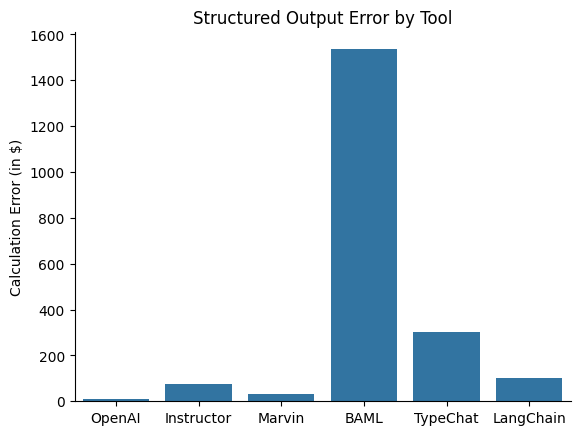

In [25]:
results = [structured_output_error, instructor_error, marvin_error, baml_error, typechat_error, langchain_error]
titles = ['OpenAI', 'Instructor', 'Marvin', 'BAML', 'TypeChat', 'LangChain']

sns.barplot(x=titles, y=results)

plt.title('Structured Output Error by Tool')
plt.ylabel('Calculation Error (in $)')

sns.despine()

plt.show()

### The Solution: Multi-Step Approach Using **💧 Instill VDP**

This problem is easily solved using an Instill VDP pipeline that separates reasoning and structuring tasks into a two-step process. It first generates an unstructured reasoning response which is then passed to a second component which is solely responsible for structuring the reasoning response into the desired data model. The final output is delivered as a JSON object.

Please view and explore the components and structure of the [`multistep-structured-output`](https://instill.tech/george_strong/pipelines/multistep-structured-output/playground) pipeline in the no-code editor window shown below. Note that you can expand the components in the pipeline by selecting the `+` icon.

In [26]:
IFrame('https://instill.tech/george_strong/pipelines/multistep-structured-output/preview', width=1000, height=800)

In [27]:
openai_multi_structured = client.pipeline_service.trigger_pipeline(
    'multistep-structured-output', [],
    [{"context": context,
      "question": question}])

openai_multi_structured_dict = MessageToDict(openai_multi_structured)['outputs'][0]['answer']
openai_multi_structured_dict

{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java'],
 'cost': 2215.0}

In [28]:
multi_structured_output_error = abs(openai_multi_structured_dict["cost"]-true_answer)
print(f'Cost calculation error: ${multi_structured_output_error}')

Cost calculation error: $0.0


Despite using two LLM inferences, it is important to note that the cost will likely still be less than many of the structuring output tools that have been considered, as these sometimes rely on making repeat API calls with modified prompts until the output can be successfully parsed into the required data model.